In [1]:
import os
import re
import uproot
import h5py
import itertools
import scipy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy import interpolate

# Function 

In [2]:
def DeltaR(eta1,phi1, eta2,phi2):
    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)
    if dPhi > np.pi:
        dPhi = 2*np.pi - dPhi

    dR = (dPhi**2 + dEta**2)**0.5

    return dR

def FourMomentum(pt, eta, phi, m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    return e, px, py, pz

def PtEtaPhiM(px, py, pz, e):
    E, px, py, pz = e, px, py, pz  
    P = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    eta = 1./2.*np.log((P + pz)/(P - pz))
    phi = np.arctan(py/px)
    m = np.sqrt(np.sqrt((E**2 - px**2 - py**2 - pz**2)**2))

    return pt, eta, phi, m
    
def InvM(e, px, py, pz):
    return np.sqrt(np.sum(e)**2 - np.sum(px)**2 - np.sum(py)**2 - np.sum(pz)**2)

def Mjets(*arg):
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

In [3]:
def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest              

In [4]:
def get_info(path):
    # path: run path
    name = os.path.split(path)[1]

    with open(os.path.join(path, f'{name}_tag_1_banner.txt')) as f:
        for line in f.readlines():
            match = re.match(' +10 (-?.*?) # khhh', line)
            if match:
                kappa = float(match.group(1))
                
            #  Integrated weight (pb)  :       0.020257
            match = re.match('#  Integrated weight \(pb\)  : +(\d+\.\d+)', line)
            if match:
                # unit: fb
                cross_section = float(match.group(1)) * 1000
            
            #  Number of Events        :       100000
            match = re.match('#  Number of Events        : +(\d+)', line)
            if match:
                nevent = int(match.group(1))
    
    return kappa, cross_section, nevent

## Selection

In [5]:
def deltaR_condition(R1, R2, m4j):
    # R1: Delta R of leading Higgs candidate
    # R2: Delta R of sub-leading Higgs candidate
    
    if m4j < 1250:
        if R1 > 653 / m4j + 0.475:
            return False
        if R1 < 360 / m4j - 0.5:
            return False

        if R2 > 875 / m4j + 0.35:
            return False
        if R2 < 235 / m4j:
            return False      
    else:
        if R1 > 1:
            return False
        if R1 < 0:
            return False

        if R2 > 1:
            return False
        if R2 < 0:
            return False
    return True  

def DHH(m1, m2):
    # m1: mass of leading Higgs candidate
    # m2: mass of sub-leading Higgs candidate
    
    return abs(m1 - 120/110*m2) / (1 + (120/110)**2)**0.5
    
def pt_condition(pt1, pt2, m4j):
    # pt1: PT of leading Higgs candidate
    # pt2: PT of sub-leading Higgs candidate
    
    if pt1 < 0.5 * m4j - 103:
        return False
    if pt2 < 0.33 * m4j - 73:
        return False
    return True

def XHH(m1, m2, m10=120, m20=110):
    # m1: leading Higgs candidate mass
    # m2: sub-leading Higgs candidate mass
    
    return (((m1-m10)/(0.1*m1))**2 + ((m2-m20)/(0.1*m2))**2)**0.5

def XWt(mW, mt):
    # mW: W boson candidate mass
    # mt: top candidate mass
    
    return (((mW-80)/(0.1*mW))**2 + ((mt-173)/(0.1*mt))**2)**0.5

def DHH_dR_method(PT, Eta, Phi, Mass):
    # get the pairing by DeltaR method
    # 已經過 preseleciton PT, Eta, Phi, Mass都只有4個jets的資料
    
    # Total invariant mass of 4 b-jets
    e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
    m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))
    
    pairing = []
    for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):
        PT1 = PT[[i1,i2]]
        PT2 = PT[[i3,i4]]
        # sorted by PT scalar sum
        if np.sum(PT1) < np.sum(PT2):
            i1, i2, i3, i4 = i3, i4, i1, i2

        PT1 = PT[[i1,i2]] 
        Eta1 = Eta[[i1,i2]]
        Phi1 = Phi[[i1,i2]]
        Mass1 = Mass[[i1,i2]]

        e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
        mH1 = InvM(np.sum(e1), np.sum(px1), np.sum(py1), np.sum(pz1))

        PT2 = PT[[i3,i4]]
        Eta2 = Eta[[i3,i4]]
        Phi2 = Phi[[i3,i4]]
        Mass2 = Mass[[i3,i4]]

        e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
        mH2 = InvM(np.sum(e2), np.sum(px2), np.sum(py2), np.sum(pz2))

        dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
        dR2 = DeltaR(Eta2[0], Phi2[0], Eta2[1], Phi2[1])

        if deltaR_condition(dR1, dR2, m4j):
            d = DHH(mH1, mH2)
            pairing.append([i1,i2,i3,i4, d])
    
    if len(pairing) == 0:
        return pairing
    
    # choose the pairing with minimum DHH
    h_candidate = pairing[0][0:4]
    min_DHH = pairing[0][4]
    for i1,i2,i3,i4, d in pairing:
        if d < min_DHH:
            min_DHH = d
            h_candidate = [i1,i2,i3,i4]

    return h_candidate

def top_veto(PT, Eta, Phi, M, h_jets, central_jets):
    # PT, Eta, Phi, M are jets 4-momentum
    # h_jets: the index of h jets candidate
    # central_jets: index of central jets
    
    XWt_flag = False
    for b in h_jets:
        PTb = PT[b]
        Etab = Eta[b]
        Phib = Phi[b]
        Massb = M[b]
        eb, pxb, pyb, pzb = FourMomentum(PTb, Etab, Phib, Massb)

        for i1,i2 in itertools.combinations(central_jets, 2):
            if b == i1 or b == i2:
                continue
            PTW = PT[[i1,i2]]
            EtaW = Eta[[i1,i2]]
            PhiW = Phi[[i1,i2]]
            MassW = M[[i1,i2]]

            eW, pxW, pyW, pzW = FourMomentum(PTW, EtaW, PhiW, MassW)
            mW = InvM(np.sum(eW), np.sum(pxW), np.sum(pyW), np.sum(pzW))

            et, pxt, pyt, pzt = np.sum(eW) + eb, np.sum(pxW) + pxb, np.sum(pyW) + pyb, np.sum(pzW) + pzb
            mt = InvM(et, pxt, pyt, pzt)

            if XWt(mW, mt) < 1.5:
                XWt_flag = True
                return XWt_flag

    return XWt_flag

def min_dR_method(PT, Eta, Phi, Mass):
    # get h-jets pairing
    pairing = []
    for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):

        PT1 = PT[[i1,i2]] 
        Eta1 = Eta[[i1,i2]]
        Phi1 = Phi[[i1,i2]]
        Mass1 = Mass[[i1,i2]]
        
        e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
        PTH1, EtaH1, PhiH1, _ = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

        PT2 = PT[[i3,i4]]
        Eta2 = Eta[[i3,i4]]
        Phi2 = Phi[[i3,i4]]
        Mass2 = Mass[[i3,i4]]

        e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
        PTH2, EtaH2, PhiH2, _ = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))
        
        # sorted by PT vector sum
        if PTH1 < PTH2:
            i1, i2, i3, i4 = i3, i4, i1, i2
            PTH1, EtaH1, PhiH1, PTH2, EtaH2, PhiH2 = PTH2, EtaH2, PhiH2, PTH1, EtaH1, PhiH1

        dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
        pairing.append([i1,i2,i3,i4, dR1])
    
    h_candidate = pairing[0][0:4]
    min_dR = pairing[0][4]
    for i1,i2,i3,i4, dR in pairing:
        if dR < min_dR:
            min_dR = dR
            h_candidate = [i1,i2,i3,i4]
            
    return h_candidate  

def SPANet_pairing(PT, Eta, Phi, Mass):
    # 已經過 preseleciton PT, Eta, Phi, Mass只有4個jets的資料
    i1, i2, i3, i4 = 0,1,2,3
    
    PT1 = PT[[i1,i2]] 
    Eta1 = Eta[[i1,i2]]
    Phi1 = Phi[[i1,i2]]
    Mass1 = Mass[[i1,i2]]

    e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
    PTH1, _, _, _ = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

    PT2 = PT[[i3,i4]]
    Eta2 = Eta[[i3,i4]]
    Phi2 = Phi[[i3,i4]]
    Mass2 = Mass[[i3,i4]]

    e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
    PTH2, _, _, _ = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))

    # sorted by PT vector sum
    if PTH1 > PTH2:
        return [0, 1, 2, 3]
    else:
        return [2, 3, 0, 1]
    
def print_count_xsection(text, cross_section, count, total):
    print(text, count, cross_section * count / total)

In [6]:
def diHiggs_selection_HDF5(file_path, tot_event, pairing_method, xection=None, title='', nevent_max=1000):
    # 已經過 |eta| < 2.5, PT > 40 GeV for 4 jets, >= 4 b-jets 篩選，並且通過 SPANet
    
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        dR_count = 0
        HEta_count = 0
        XWt_count = 0
        XHH_count = 0

        cross_section = xection
        
        nevent = min(f['source/pt'].shape[0], nevent_max)
        mh = [[], []]
        mhh = []
        
        for event in tqdm(range(nevent)):   
            nj = f['source/mask'][event].sum()
            # 須將資料標準化還原
            jet_PT = np.exp(f['source/pt'][event][:nj])
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = np.exp(f['source/mass'][event][:nj])
            jet_BTag = f['source/btag'][event][:nj]

            # |eta| < 2.5 & PT > 40 GeV
            eta_pt_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40))[0]

            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag == 1))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4: 
                continue
            Eta_PT_BTag_count += 1        
                      
            if pairing_method == 'min_dR':
                # choose 4 highest pt b-jets
                h_jets = eta_pt_bTag_cut[0:4]
                
                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets] 
                h_candidate = min_dR_method(PT, Eta, Phi, Mass)
            elif pairing_method == 'SPANET':
                h_jets = [f['h1/b1'][event], f['h1/b2'][event], 
                          f['h2/b1'][event], f['h2/b2'][event],]
                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets]         
                h_candidate = SPANet_pairing(PT, Eta, Phi, Mass)
            else:
                print('Wrong pairing method')
                
            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))

            i1, i2, i3, i4 = h_candidate[0:4] 

            PT1 = PT[[i1,i2]]
            Eta1 = Eta[[i1,i2]]
            Phi1 = Phi[[i1,i2]]
            Mass1 = Mass[[i1,i2]]

            e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
            PTH1, EtaH1, PhiH1, MassH1 = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

            PT2 = PT[[i3,i4]]
            Eta2 = Eta[[i3,i4]]
            Phi2 = Phi[[i3,i4]]
            Mass2 = Mass[[i3,i4]]

            e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
            PTH2, EtaH2, PhiH2, MassH2 = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))

            # |dEta_HH| < 1.5
            if abs(EtaH1 - EtaH2) > 1.5:
                continue
            HEta_count += 1

            # Top veto
            XWt_flag = top_veto(jet_PT, jet_Eta, jet_Phi, jet_Mass, h_jets, eta_pt_cut)
            if XWt_flag:
                continue
            XWt_count += 1
            
            mh[0].append(MassH1)
            mh[1].append(MassH2)

            # signal region
            if XHH(MassH1, MassH2, 124, 117) > 1.6:
                continue
            XHH_count += 1
            
            mhh.append(m4j)

#         print(title)
#         print(f'In {nevent} events')
#         print(f'Cross section: {cross_section} fb')

#         print_count_xsection('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', cross_section, f['source/pt'].shape[0], tot_event)
#         # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
        cross_section_abs = cross_section * f['source/pt'].shape[0] / tot_event
        
#         print_count_xsection('Higgs Eta:', cross_section_abs, HEta_count, nevent)
#         print_count_xsection('Top veto:', cross_section_abs, XWt_count, nevent)
#         print_count_xsection('Higgs signal region:', cross_section_abs, XHH_count, nevent)
               
        cutflow_count = {
            'nevent': tot_event,
            'Cross section': cross_section,
            'Eta PT BTag cut': Eta_PT_BTag_count,
            'Higgs Eta cut': HEta_count,
            'Top veto': XWt_count,
            'Higgs signal': XHH_count,
        }
         
        cutflow_cross_section = {
            'nevent': nevent,
            'Cross section': cross_section,
            'Eta PT BTag cut': cross_section_abs,
            'Higgs Eta cut': cross_section_abs * HEta_count / nevent,
            'Top veto': cross_section_abs * XWt_count / nevent, 
            'Higgs signal': cross_section_abs * XHH_count / nevent,        
        }
        
        results = {
            'cutflow count': cutflow_count,
            'cutflow cross section':cutflow_cross_section,
            'mh': mh,
            'mhh': mhh,
        }
        
        return results

In [7]:
# negative log likelyhood
def NLL(N_sig, N_bkg, N_obv=None):
    N_pre = N_sig + N_bkg
    if not N_obv:
        N_obv = N_bkg
    
    return -2 * (-N_pre + N_obv * np.log(N_pre)).sum()

# Parameters

In [8]:
n_bin = 10
hist_range = [200, 1000]
L = 139

# $m_{HH}$ distribution

## $\text{min-}\Delta R$ 

In [13]:
# Background
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_DL1r_PT40_pp4b_predict.h5'
tot_event = 1000000
xection = 628589.0502929688
pairing_method = 'min_dR'
min_4b = diHiggs_selection_HDF5(file_path, 
                                tot_event,
                                pairing_method,
                                xection,
                                title='pp->4b', 
                                nevent_max=10000)

# SM kappa=1
file_path = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/run_17_decayed_1/DiHiggs_4b_PT40-predict.h5'
tot_event = 100000
xection = 20.251 * 0.582 * 0.582
pairing_method = 'min_dR'
min_s = diHiggs_selection_HDF5(file_path, 
                                tot_event, 
                                pairing_method,   
                                xection,
                                title='pp->hh', 
                                nevent_max=10000)

file_path = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/run_28_decayed_1/DiHiggs_4b_PT40-predict.h5'
sample_dir = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/'
i=28
info = get_info(os.path.join(sample_dir, f'run_{i:02}'))
print(info)

xection = info[1] * 0.582 * 0.582
tot_event = info[2]

# selection
file_path = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40-predict.h5')
min_k12 = diHiggs_selection_HDF5(file_path, 
                                tot_event, 
                                pairing_method,   
                                xection,
                                title='pp->hh', 
                                nevent_max=10000)

n, bin_edges = np.histogram(min_k12['mhh'], bins=n_bin, range=hist_range)
min_k12 = n / tot_event * xection * L

file_path = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/run_11_decayed_1/DiHiggs_4b_PT40-predict.h5'
i=11
info = get_info(os.path.join(sample_dir, f'run_{i:02}'))
print(info)

xection = info[1] * 0.582 * 0.582
tot_event = info[2]

# selection
file_path = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40-predict.h5')
min_k_5 = diHiggs_selection_HDF5(file_path, 
                                tot_event, 
                                pairing_method,   
                                xection,
                                title='pp->hh', 
                                nevent_max=10000)

n, bin_edges = np.histogram(min_k_5['mhh'], bins=n_bin, range=hist_range)
min_k_5 = n / tot_event * xection * L

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8479/8479 [00:34<00:00, 244.92it/s]


(12.0, 508.24, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4815/4815 [00:17<00:00, 269.77it/s]


(-5.0, 316.29, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5905/5905 [00:22<00:00, 260.50it/s]


In [15]:
tot_event = 1000000
xection = 628589.0502929688

n, bin_edges = np.histogram(min_4b['mhh'], bins=n_bin, range=hist_range)
min_bkg = n / tot_event * xection * L

tot_event = 100000
xection = 20.251 * 0.582 * 0.582

n, bin_edges = np.histogram(min_s['mhh'], bins=n_bin, range=hist_range)
min_sig = n / tot_event * xection * L

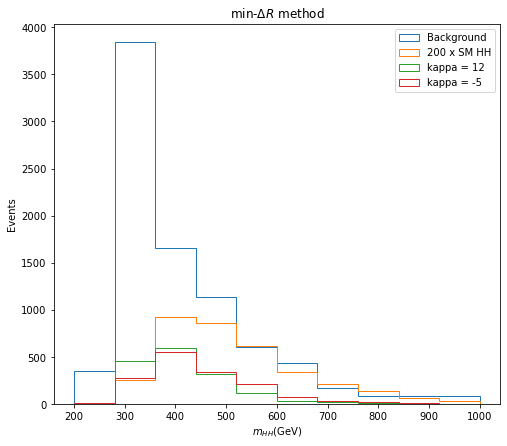

In [21]:
fig, ax = plt.subplots(1, 1, figsize =(8, 7))

ax.hist(np.linspace(*hist_range,n_bin), bins=n_bin, range=hist_range, weights=min_bkg, histtype='step', label='Background')
ax.hist(np.linspace(*hist_range,n_bin), bins=n_bin, range=hist_range, weights=min_sig*200, histtype='step', label='200 x SM HH')
ax.hist(np.linspace(*hist_range,n_bin), bins=n_bin, range=hist_range, weights=min_k12*10, histtype='step', label='$\kappa = 12$')
ax.hist(np.linspace(*hist_range,n_bin), bins=n_bin, range=hist_range, weights=min_k_5*10, histtype='step', label='$\kappa = -5$')

ax.set_xlabel('$m_{HH}$(GeV)')
ax.set_ylabel('Events')
ax.set_title('min-$\Delta R$ method')

ax.legend()
# plt.savefig('figures/mhh_distribution_min_dR.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

## SPANET

In [22]:
# Background
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_DL1r_PT40_pp4b_predict.h5'
tot_event = 1000000
xection = 628589.0502929688
pairing_method = 'SPANET'
SPANET_4b = diHiggs_selection_HDF5(file_path, 
                                tot_event,
                                pairing_method,
                                xection,
                                title='pp->4b', 
                                nevent_max=10000)


# SM kappa=1
file_path = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/run_17_decayed_1/DiHiggs_4b_PT40-predict.h5'
tot_event = 100000
xection = 20.251 * 0.582 * 0.582
pairing_method = 'SPANET'
SPANET_s = diHiggs_selection_HDF5(file_path, 
                                tot_event, 
                                pairing_method,   
                                xection,
                                title='pp->hh', 
                                nevent_max=10000)
n, bin_edges = np.histogram(min_s['mhh'], bins=n_bin, range=hist_range)
N_sig = n / tot_event * xection * L

file_path = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/run_28_decayed_1/DiHiggs_4b_PT40-predict.h5'
sample_dir = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/'
i=28
info = get_info(os.path.join(sample_dir, f'run_{i:02}'))
print(info)

xection = info[1] * 0.582 * 0.582
tot_event = info[2]

# selection
file_path = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40-predict.h5')
min_k12 = diHiggs_selection_HDF5(file_path, 
                                tot_event, 
                                pairing_method,   
                                xection,
                                title='pp->hh', 
                                nevent_max=10000)

n, bin_edges = np.histogram(min_k12['mhh'], bins=n_bin, range=hist_range)
min_k12_S = n / tot_event * xection * L

file_path = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/run_11_decayed_1/DiHiggs_4b_PT40-predict.h5'
i=11
info = get_info(os.path.join(sample_dir, f'run_{i:02}'))
print(info)

xection = info[1] * 0.582 * 0.582
tot_event = info[2]

# selection
file_path = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40-predict.h5')
min_k_5 = diHiggs_selection_HDF5(file_path, 
                                tot_event, 
                                pairing_method,   
                                xection,
                                title='pp->hh', 
                                nevent_max=10000)

n, bin_edges = np.histogram(min_k_5['mhh'], bins=n_bin, range=hist_range)
min_k_5_S = n / tot_event * xection * L

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8479/8479 [00:37<00:00, 228.82it/s]


(12.0, 508.24, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4815/4815 [00:20<00:00, 232.71it/s]


(-5.0, 316.29, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5905/5905 [00:25<00:00, 228.80it/s]


In [23]:
tot_event = 1000000
xection = 628589.0502929688

n, bin_edges = np.histogram(SPANET_4b['mhh'], bins=n_bin, range=hist_range)
SPANET_bkg = n / tot_event * xection * L

tot_event = 100000
xection = 20.251 * 0.582 * 0.582

n, bin_edges = np.histogram(SPANET_s['mhh'], bins=n_bin, range=hist_range)
SPANET_sig = n / tot_event * xection * L

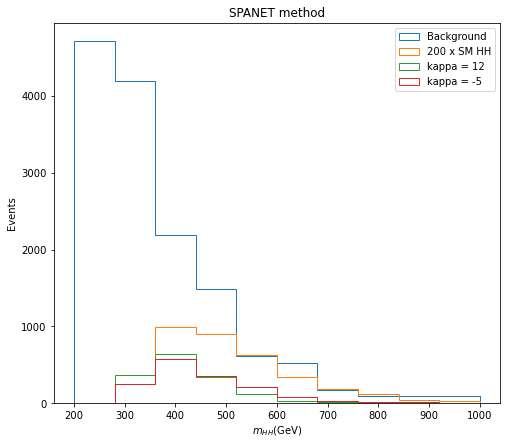

In [24]:
fig, ax = plt.subplots(1, 1, figsize =(8, 7))

ax.hist(np.linspace(*hist_range,n_bin), bins=n_bin, range=hist_range, weights=SPANET_bkg, histtype='step', label='Background')
ax.hist(np.linspace(*hist_range,n_bin), bins=n_bin, range=hist_range, weights=SPANET_sig*200, histtype='step', label='200 x SM HH')
ax.hist(np.linspace(*hist_range,n_bin), bins=n_bin, range=hist_range, weights=min_k12_S*10, histtype='step', label='kappa = 12')
ax.hist(np.linspace(*hist_range,n_bin), bins=n_bin, range=hist_range, weights=min_k_5_S*10, histtype='step', label='kappa = -5')
ax.set_xlabel('$m_{HH}$(GeV)')
ax.set_ylabel('Events')
ax.set_title('SPANET method')

ax.legend()
# plt.savefig('figures/mhh_distribution_SPANET.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

# Set constraints of $\kappa_\lambda$

## $\text{min-}\Delta R$

In [15]:
pairing_method = 'min_dR'

### Background

In [16]:
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_DL1r_PT40_pp4b_predict.h5'
tot_event = 1000000
xection = 628589.0502929688
min_4b = diHiggs_selection_HDF5(file_path, 
                                tot_event,
                                pairing_method,
                                xection,
                                title='pp->4b', 
                                nevent_max=10000)
# binned
n, bin_edges = np.histogram(min_4b['mhh'], bins=n_bin, range=hist_range)

min_bkg = n / tot_event * xection * L

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:30<00:00, 316.93it/s]


### Scan $\kappa_\lambda$

In [17]:
kappas = []
NLLs = []

for i in range(6,32):
    sample_dir = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/'
    info = get_info(os.path.join(sample_dir, f'run_{i:02}'))
    print(info)
    kappas.append(info[0])
    xection = info[1] * 0.582 * 0.582
    tot_event = info[2]
    
    # selection
    file_path = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40-predict.h5')
    result_s = diHiggs_selection_HDF5(file_path, 
                                    tot_event, 
                                    pairing_method,   
                                    xection,
                                    title='pp->hh', 
                                    nevent_max=10000)
    
    # bin
    n, bin_edges = np.histogram(result_s['mhh'], bins=n_bin, range=hist_range)
    N_sig = n / tot_event * xection * L

    # NLL 
    NLLs.append(NLL(N_sig, min_bkg))  

(-10.0, 865.4300000000001, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5628/5628 [00:23<00:00, 242.50it/s]


(-9.0, 734.02, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5698/5698 [00:23<00:00, 241.81it/s]


(-8.0, 612.39, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5658/5658 [00:23<00:00, 240.64it/s]


(-7.0, 502.6, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5699/5699 [00:23<00:00, 240.09it/s]


(-6.0, 403.62, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5878/5878 [00:24<00:00, 242.08it/s]


(-5.0, 316.29, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5905/5905 [00:24<00:00, 242.16it/s]


(-4.0, 239.21, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6047/6047 [00:25<00:00, 241.64it/s]


(-3.0, 173.11, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6234/6234 [00:26<00:00, 235.46it/s]


(-2.0, 118.59, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6488/6488 [00:27<00:00, 238.40it/s]


(-1.0, 74.776, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6770/6770 [00:28<00:00, 236.54it/s]


(0.0, 42.007999999999996, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7283/7283 [00:31<00:00, 231.19it/s]


(1.0, 20.251, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8479/8479 [00:37<00:00, 228.82it/s]


(2.0, 9.519599999999999, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9382/9382 [00:42<00:00, 223.04it/s]


(3.0, 9.818900000000001, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6615/6615 [00:28<00:00, 232.16it/s]


(4.0, 21.144, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4657/4657 [00:18<00:00, 247.35it/s]


(5.0, 43.476, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4273/4273 [00:17<00:00, 246.67it/s]


(6.0, 76.793, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4380/4380 [00:17<00:00, 254.51it/s]


(7.0, 121.21, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4517/4517 [00:18<00:00, 249.77it/s]


(8.0, 176.6, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4605/4605 [00:18<00:00, 248.66it/s]


(9.0, 243.10000000000002, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4668/4668 [00:18<00:00, 249.71it/s]


(10.0, 320.37, 100000)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 386.73it/s]


(11.0, 408.92, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4768/4768 [00:19<00:00, 248.57it/s]


(12.0, 508.24, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4815/4815 [00:19<00:00, 250.70it/s]


(13.0, 618.63, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:19<00:00, 252.11it/s]


(14.0, 739.65, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4866/4866 [00:19<00:00, 249.12it/s]


(15.0, 873.59, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4841/4841 [00:19<00:00, 245.72it/s]


In [18]:
NLLs = np.array(NLLs)

LL_r = NLLs - NLLs.min()

x = np.array(kappas)
arg = x.argsort()
x = x[arg]
y = LL_r[arg]

f = interpolate.UnivariateSpline(x, y, s=0, k=3)

x_new = np.linspace(x.min(), x.max(), 100)
y_new = f(x_new)

In [19]:
def find_root(f, x0, x1):
    if f(x0) * f(x1) > 0:
        print('Wrong Guess')
    else:
        tol = 1e-12
        while abs(f(x0)) > tol:
            c = (x0 + x1)/2
            if f(c) * f(x0) > 0:
                x0, x1 = c, x1
            else:
                x0, x1 = x0, c
        return x0
    
def g(x):
    return f(x) - 4

r1 = find_root(g, -10, 0)
r2 = find_root(g, 15, 0)

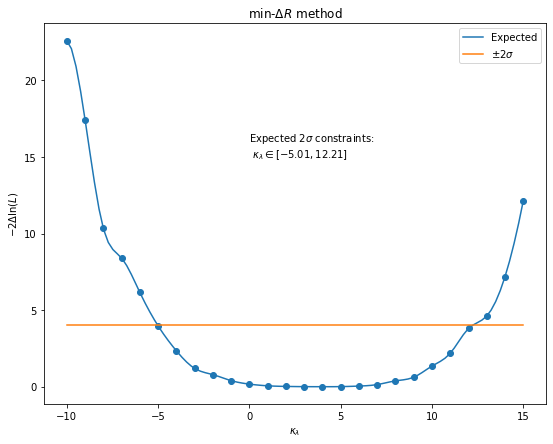

In [20]:
fig, ax = plt.subplots(1, 1, figsize =(9, 7))
ax.scatter(kappas, LL_r)
ax.plot(x_new, y_new, label='Expected')
ax.plot(x_new, np.ones_like(x_new)*4, label='$\pm 2 \sigma$')
ax.set_xlabel('$\kappa_\lambda$')
ax.set_ylabel('$-2\Delta\ln(L)$')
ax.set_title('min-$\Delta R$ method')
if r1 and r2:
    ax.text(0, 15, f'Expected $2\sigma$ constraints:\n $\kappa_\lambda\in[{r1:.2f},{r2:.2f}]$')

ax.legend()
plt.savefig('figures/log_likelihood_ratio_kappa_min_dR.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

## SPANET

In [21]:
pairing_method = 'SPANET'

### Background

In [22]:
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_DL1r_PT40_pp4b_predict.h5'
tot_event = 1000000
xection = 628589.0502929688
SPANET_4b = diHiggs_selection_HDF5(file_path, 
                                tot_event,
                                pairing_method,
                                xection,
                                title='pp->4b', 
                                nevent_max=10000)
# binned
n, bin_edges = np.histogram(SPANET_4b['mhh'], bins=n_bin, range=hist_range)
SPANET_bkg = n / tot_event * xection * L

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:33<00:00, 290.90it/s]


### Scan $\kappa_\lambda$

In [24]:
kappas = []
NLLs = []

for i in range(6,32):
    sample_dir = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/'
    info = get_info(os.path.join(sample_dir, f'run_{i:02}'))
    print(info)
    kappas.append(info[0])
    xection = info[1] * 0.582 * 0.582
    tot_event = info[2]
    
    # selection
    file_path = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40-predict.h5')
    result_s = diHiggs_selection_HDF5(file_path, 
                                    tot_event, 
                                    pairing_method,   
                                    xection,
                                    title='pp->hh', 
                                    nevent_max=10000)
    
    # bin
    n, bin_edges = np.histogram(result_s['mhh'], bins=n_bin, range=hist_range)
    N_sig = n / tot_event * xection * L

    # NLL 
    NLLs.append(NLL(N_sig, SPANET_bkg))  

(-10.0, 865.4300000000001, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5628/5628 [00:25<00:00, 223.09it/s]


(-9.0, 734.02, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5698/5698 [00:25<00:00, 224.35it/s]


(-8.0, 612.39, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5658/5658 [00:25<00:00, 222.46it/s]


(-7.0, 502.6, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5699/5699 [00:25<00:00, 222.21it/s]


(-6.0, 403.62, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5878/5878 [00:26<00:00, 221.32it/s]


(-5.0, 316.29, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5905/5905 [00:26<00:00, 223.49it/s]


(-4.0, 239.21, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6047/6047 [00:27<00:00, 221.46it/s]


(-3.0, 173.11, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6234/6234 [00:28<00:00, 221.94it/s]


(-2.0, 118.59, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6488/6488 [00:28<00:00, 228.24it/s]


(-1.0, 74.776, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6770/6770 [00:31<00:00, 214.18it/s]


(0.0, 42.007999999999996, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7283/7283 [00:32<00:00, 223.61it/s]


(1.0, 20.251, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8479/8479 [00:38<00:00, 220.13it/s]


(2.0, 9.519599999999999, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9382/9382 [00:43<00:00, 217.49it/s]


(3.0, 9.818900000000001, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6615/6615 [00:30<00:00, 216.28it/s]


(4.0, 21.144, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4657/4657 [00:19<00:00, 239.54it/s]


(5.0, 43.476, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4273/4273 [00:17<00:00, 238.05it/s]


(6.0, 76.793, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4380/4380 [00:18<00:00, 242.78it/s]


(7.0, 121.21, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4517/4517 [00:18<00:00, 238.97it/s]


(8.0, 176.6, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4605/4605 [00:19<00:00, 237.00it/s]


(9.0, 243.10000000000002, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4668/4668 [00:19<00:00, 238.65it/s]


(10.0, 320.37, 100000)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 376.38it/s]


(11.0, 408.92, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4768/4768 [00:20<00:00, 236.14it/s]


(12.0, 508.24, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4815/4815 [00:20<00:00, 238.60it/s]


(13.0, 618.63, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:20<00:00, 238.02it/s]


(14.0, 739.65, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4866/4866 [00:20<00:00, 235.03it/s]


(15.0, 873.59, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4841/4841 [00:20<00:00, 236.94it/s]


In [25]:
NLLs = np.array(NLLs)
LL_r = NLLs - NLLs.min()

x = np.array(kappas)
arg = x.argsort()
x = x[arg]
y = LL_r[arg]

# interpolate
f = interpolate.UnivariateSpline(x, y, s=0, k=3)

x_new = np.linspace(x.min(), x.max(), 100)
y_new = f(x_new)

In [26]:
def find_root(f, x0, x1):
    if f(x0) * f(x1) > 0:
        print('Wrong Guess')
    else:
        tol = 1e-12
        while abs(f(x0)) > tol:
            c = (x0 + x1)/2
            if f(c) * f(x0) > 0:
                x0, x1 = c, x1
            else:
                x0, x1 = x0, c
        return x0
    
def g(x):
    return f(x) - 4

r1 = find_root(g, -10, 0)
r2 = find_root(g, 15, 0)

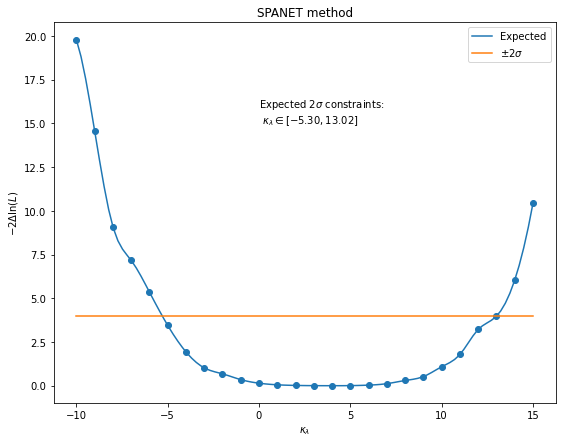

In [27]:
fig, ax = plt.subplots(1, 1, figsize =(9, 7))
ax.scatter(kappas, LL_r)
ax.plot(x_new, y_new, label='Expected')
ax.plot(x_new, np.ones_like(x_new)*4, label='$\pm 2 \sigma$')
ax.set_xlabel('$\kappa_\lambda$')
ax.set_ylabel('$-2\Delta\ln(L)$')
ax.set_title('SPANET method')
if r1 and r2:
    ax.text(0, 15, f'Expected $2\sigma$ constraints:\n $\kappa_\lambda\in[{r1:.2f},{r2:.2f}]$')

ax.legend()
plt.savefig('figures/log_likelihood_ratio_kappa_SPANET.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

## $\text{min-}\Delta R$

In [17]:
pairing_method = 'min_dR'

### Background

In [19]:
file_path = '/home/r10222035/CPVDM/h5_data/2M_diHiggs_4b_PT40_background-predict.h5'
tot_event = 1000000
xection = 628589.0502929688
min_4b = diHiggs_selection_HDF5(file_path, 
                                tot_event,
                                pairing_method,
                                xection,
                                title='pp->4b', 
                                nevent_max=50000)
# binned
n, bin_edges = np.histogram(min_4b['mhh'], bins=n_bin, range=hist_range)

min_bkg = n / tot_event * xection * L

100%|████████████████████████████████████| 20355/20355 [01:00<00:00, 338.35it/s]


### Scan $\kappa_\lambda$

In [20]:
kappas = []
NLLs = []

for i in range(6,32):
    sample_dir = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/'
    info = get_info(os.path.join(sample_dir, f'run_{i:02}'))
    print(info)
    kappas.append(info[0])
    xection = info[1] * 0.582 * 0.582
    tot_event = info[2]
    
    # selection
    file_path = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40-predict.h5')
    result_s = diHiggs_selection_HDF5(file_path, 
                                    tot_event, 
                                    pairing_method,   
                                    xection,
                                    title='pp->hh', 
                                    nevent_max=10000)
    
    # bin
    n, bin_edges = np.histogram(result_s['mhh'], bins=n_bin, range=hist_range)
    N_sig = n / tot_event * xection * L

    # NLL 
    NLLs.append(NLL(N_sig, min_bkg))  

(-10.0, 865.4300000000001, 100000)


100%|██████████████████████████████████████| 5628/5628 [00:21<00:00, 265.32it/s]


(-9.0, 734.02, 100000)


100%|██████████████████████████████████████| 5698/5698 [00:21<00:00, 265.86it/s]


(-8.0, 612.39, 100000)


100%|██████████████████████████████████████| 5658/5658 [00:21<00:00, 264.12it/s]


(-7.0, 502.6, 100000)


100%|██████████████████████████████████████| 5699/5699 [00:21<00:00, 263.12it/s]


(-6.0, 403.62, 100000)


100%|██████████████████████████████████████| 5878/5878 [00:22<00:00, 265.14it/s]


(-5.0, 316.29, 100000)


100%|██████████████████████████████████████| 5905/5905 [00:22<00:00, 267.79it/s]


(-4.0, 239.21, 100000)


100%|██████████████████████████████████████| 6047/6047 [00:22<00:00, 265.90it/s]


(-3.0, 173.11, 100000)


100%|██████████████████████████████████████| 6234/6234 [00:23<00:00, 262.45it/s]


(-2.0, 118.59, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6488/6488 [00:24<00:00, 264.03it/s]


(-1.0, 74.776, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6770/6770 [00:25<00:00, 262.24it/s]


(0.0, 42.007999999999996, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7283/7283 [00:32<00:00, 222.96it/s]


(1.0, 20.251, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8479/8479 [00:38<00:00, 219.89it/s]


(2.0, 9.519599999999999, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9382/9382 [00:42<00:00, 218.86it/s]


(3.0, 9.818900000000001, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6615/6615 [00:28<00:00, 230.39it/s]


(4.0, 21.144, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4657/4657 [00:17<00:00, 267.93it/s]


(5.0, 43.476, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4273/4273 [00:15<00:00, 272.80it/s]


(6.0, 76.793, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4380/4380 [00:15<00:00, 274.74it/s]


(7.0, 121.21, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4517/4517 [00:16<00:00, 276.84it/s]


(8.0, 176.6, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4605/4605 [00:16<00:00, 275.19it/s]


(9.0, 243.10000000000002, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4668/4668 [00:16<00:00, 275.84it/s]


(10.0, 320.37, 100000)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.03it/s]


(11.0, 408.92, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4768/4768 [00:18<00:00, 255.99it/s]


(12.0, 508.24, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4815/4815 [00:17<00:00, 273.55it/s]


(13.0, 618.63, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4827/4827 [00:17<00:00, 275.79it/s]


(14.0, 739.65, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4866/4866 [00:17<00:00, 271.92it/s]


(15.0, 873.59, 100000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4841/4841 [00:17<00:00, 269.60it/s]


In [21]:
NLLs = np.array(NLLs)

LL_r = NLLs - NLLs.min()

x = np.array(kappas)
arg = x.argsort()
x = x[arg]
y = LL_r[arg]

f = interpolate.UnivariateSpline(x, y, s=0, k=3)

x_new = np.linspace(x.min(), x.max(), 100)
y_new = f(x_new)

In [22]:
def find_root(f, x0, x1):
    if f(x0) * f(x1) > 0:
        print('Wrong Guess')
    else:
        tol = 1e-12
        while abs(f(x0)) > tol:
            c = (x0 + x1)/2
            if f(c) * f(x0) > 0:
                x0, x1 = c, x1
            else:
                x0, x1 = x0, c
        return x0
    
def g(x):
    return f(x) - 4

r1 = find_root(g, -10, 0)
r2 = find_root(g, 15, 0)

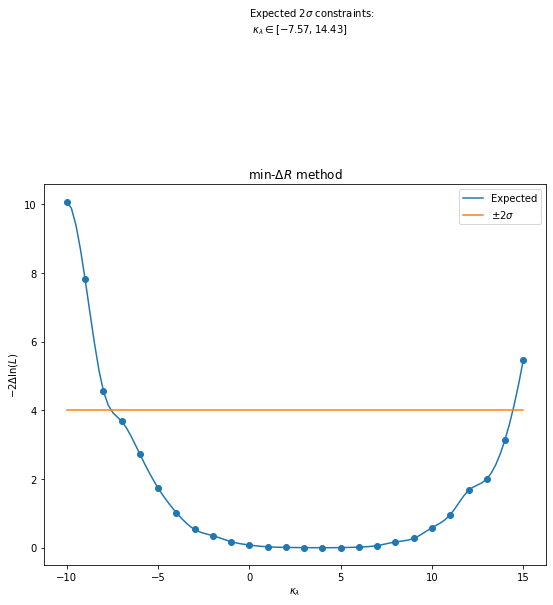

In [23]:
fig, ax = plt.subplots(1, 1, figsize =(9, 7))
ax.scatter(kappas, LL_r)
ax.plot(x_new, y_new, label='Expected')
ax.plot(x_new, np.ones_like(x_new)*4, label='$\pm 2 \sigma$')
ax.set_xlabel('$\kappa_\lambda$')
ax.set_ylabel('$-2\Delta\ln(L)$')
ax.set_title('min-$\Delta R$ method')
if r1 and r2:
    ax.text(0, 15, f'Expected $2\sigma$ constraints:\n $\kappa_\lambda\in[{r1:.2f},{r2:.2f}]$')

ax.legend()
plt.savefig('figures/log_likelihood_ratio_kappa_min_dR-2M.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

## SPANET

In [24]:
pairing_method = 'SPANET'

### Background

In [25]:
file_path = '/home/r10222035/CPVDM/h5_data/2M_diHiggs_4b_PT40_background-predict.h5
tot_event = 1000000
xection = 628589.0502929688
SPANET_4b = diHiggs_selection_HDF5(file_path, 
                                tot_event,
                                pairing_method,
                                xection,
                                title='pp->4b', 
                                nevent_max=50000)
# binned
n, bin_edges = np.histogram(SPANET_4b['mhh'], bins=n_bin, range=hist_range)
SPANET_bkg = n / tot_event * xection * L

SyntaxError: EOL while scanning string literal (3744937365.py, line 1)

### Scan $\kappa_\lambda$

In [ ]:
kappas = []
NLLs = []

for i in range(6,32):
    sample_dir = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/'
    info = get_info(os.path.join(sample_dir, f'run_{i:02}'))
    print(info)
    kappas.append(info[0])
    xection = info[1] * 0.582 * 0.582
    tot_event = info[2]
    
    # selection
    file_path = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40-predict.h5')
    result_s = diHiggs_selection_HDF5(file_path, 
                                    tot_event, 
                                    pairing_method,   
                                    xection,
                                    title='pp->hh', 
                                    nevent_max=10000)
    
    # bin
    n, bin_edges = np.histogram(result_s['mhh'], bins=n_bin, range=hist_range)
    N_sig = n / tot_event * xection * L

    # NLL 
    NLLs.append(NLL(N_sig, SPANET_bkg))  

In [ ]:
NLLs = np.array(NLLs)
LL_r = NLLs - NLLs.min()

x = np.array(kappas)
arg = x.argsort()
x = x[arg]
y = LL_r[arg]

# interpolate
f = interpolate.UnivariateSpline(x, y, s=0, k=3)

x_new = np.linspace(x.min(), x.max(), 100)
y_new = f(x_new)

In [ ]:
def find_root(f, x0, x1):
    if f(x0) * f(x1) > 0:
        print('Wrong Guess')
    else:
        tol = 1e-12
        while abs(f(x0)) > tol:
            c = (x0 + x1)/2
            if f(c) * f(x0) > 0:
                x0, x1 = c, x1
            else:
                x0, x1 = x0, c
        return x0
    
def g(x):
    return f(x) - 4

r1 = find_root(g, -10, 0)
r2 = find_root(g, 15, 0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize =(9, 7))
ax.scatter(kappas, LL_r)
ax.plot(x_new, y_new, label='Expected')
ax.plot(x_new, np.ones_like(x_new)*4, label='$\pm 2 \sigma$')
ax.set_xlabel('$\kappa_\lambda$')
ax.set_ylabel('$-2\Delta\ln(L)$')
ax.set_title('SPANET method')
if r1 and r2:
    ax.text(0, 15, f'Expected $2\sigma$ constraints:\n $\kappa_\lambda\in[{r1:.2f},{r2:.2f}]$')

ax.legend()
plt.savefig('figures/log_likelihood_ratio_kappa_SPANET-2M.png', facecolor='White', dpi=300, bbox_inches = 'tight')
plt.show()

# Selection

In [ ]:
sample_dir = '/home/r10222035/CPVDM/Di-Higgs-SM/pphh/Events/'
for i in range(26,32):
    root_file = os.path.join(sample_dir, f'run_{i:02}_decayed_1/tag_1_delphes_events.root')
    
    output_file = 'DiHiggs_4b_PT40.h5'
    output_dir = os.path.join(sample_dir, f'run_{i:02}_decayed_1/')
    output_path = os.path.join(output_dir, output_file)

    min_b = 4
    cmd = f'python /home/r10222035/CPVDM/3-4-Higgs-Collider-Study/SPANet/to_diHiggs_h5_PT40_w_pairing.py {root_file} {output_path} {min_b} &'

    print(cmd)

In [ ]:
for i in range(27,32):
    root_file = os.path.join(sample_dir, f'run_{i:02}_decayed_1/tag_1_delphes_events.root')
    
    output_file = 'DiHiggs_4b_PT40.h5'
    output_dir = os.path.join(sample_dir, f'run_{i:02}_decayed_1/')
    output_path = os.path.join(output_dir, output_file)

    old_file = os.path.join(output_dir, 'DiHiggs_4b_PT40-00.h5')
    
    if os.path.isfile(output_path):
        print(f'{output_path} exist.')
    elif not os.path.isfile(old_file):
        print(f'{old_file} not exist.')
    else: 
        os.rename(old_file, output_path)
        print(f'{old_file} ---> {output_path}')   

#  SPANET

In [ ]:
log_dir = '/home/r10222035/SPANet/diHiggs/1M_diHiggs_4b_MV2c10_PT40_450GeV/version_0/'

for i in range(27,32):
    input_file = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40.h5')
    predict_file = os.path.join(sample_dir, f'run_{i:02}_decayed_1/DiHiggs_4b_PT40-predict.h5')

    cmd = f'python predict.py {log_dir} {predict_file} -tf {input_file} --gpu'
    print(cmd)